In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# 데이터셋 경로 설정
dataset_path = './train_png_GM45'  # 데이터셋 폴더 경로
excel_path = './Dataset.xlsx'  # 엑셀 파일 경로

In [3]:
# 하이퍼파라미터 설정
image_size = (256, 256)  # 이미지 크기
batch_size = 16
epochs = 30

In [4]:
# 데이터셋 불러오기
dataset = pd.read_excel(excel_path)

image_files = [file for file in os.listdir(dataset_path) if file.endswith('.png')]

In [5]:
# 데이터셋 분할
X_train_files, X_test_files, y_train, y_test = train_test_split(
    image_files, dataset['Age'], test_size=0.2, random_state=42)

In [6]:
# 이미지 전처리 함수 정의
def preprocess_image(image_path):
    image = tf.io.read_file(os.path.join(dataset_path, image_path))
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


In [7]:
# 데이터셋 생성 함수 정의
def create_dataset(X_files, y_values):
    images = [preprocess_image(file) for file in X_files]
    images = tf.stack(images)
    labels = np.array(y_values)
    return images, labels


In [8]:
# 훈련 및 테스트 데이터셋 생성
X_train, y_train = create_dataset(X_train_files, y_train)
X_test, y_test = create_dataset(X_test_files, y_test)

In [9]:
len(X_train)

96

In [10]:
# 데이터 증강 생성기 생성
datagen = ImageDataGenerator(
    rotation_range=20,  # 이미지 회전 범위
    width_shift_range=0.1,  # 가로로 이동 범위
    height_shift_range=0.1,  # 세로로 이동 범위
    shear_range=0.2,  # 전단 변환 범위
    zoom_range=0.2,  # 확대/축소 범위
    
)

In [11]:
# 훈련 데이터셋에 데이터 증강 적용
augmented_X_train = []
augmented_y_train = []

In [12]:
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

for i in range(len(X_train)):
    X = X_train[i]
    y = y_train[i]
    for _ in range(5):  # 각 이미지마다 5개의 증강 이미지 생성
        augmented_X_train.append(datagen.random_transform(X))
        augmented_y_train.append(y)

In [13]:
augmented_X_train = np.array(augmented_X_train)
augmented_y_train = np.array(augmented_y_train)

In [14]:
# 증강된 훈련 데이터셋과 원래의 훈련 데이터셋을 결합
X_train = np.concatenate((X_train, augmented_X_train), axis=0)
y_train = np.concatenate((y_train, augmented_y_train), axis=0)

In [15]:
len(X_train)

576

In [16]:
len(X_test)

24

In [21]:
# CNN 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.Dropout(0.25),  # Dropout 추가
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.Dropout(0.25),  # Dropout 추가
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),  # Dropout 추가
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [18]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

In [19]:
# 모델 훈련
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/30
36/36 [==============================] - 5s 41ms/step - loss: 881.2413 - val_loss: 503.4663
Epoch 2/30
36/36 [==============================] - 1s 35ms/step - loss: 553.9619 - val_loss: 360.1629
Epoch 3/30
36/36 [==============================] - 1s 34ms/step - loss: 491.3556 - val_loss: 260.1943
Epoch 4/30
36/36 [==============================] - 1s 33ms/step - loss: 330.8676 - val_loss: 113.3079
Epoch 5/30
36/36 [==============================] - 1s 34ms/step - loss: 216.3581 - val_loss: 94.8299
Epoch 6/30
36/36 [==============================] - 1s 35ms/step - loss: 108.3468 - val_loss: 68.1264
Epoch 7/30
36/36 [==============================] - 1s 34ms/step - loss: 88.6896 - val_loss: 66.0770
Epoch 8/30
36/36 [==============================] - 1s 34ms/step - loss: 77.7344 - val_loss: 90.5581
Epoch 9/30
36/36 [==============================] - 1s 34ms/step - loss: 81.4186 - val_loss: 71.3900
Epoch 10/30
36/36 [==============================] - 1s 34ms/step - loss: 66.8404

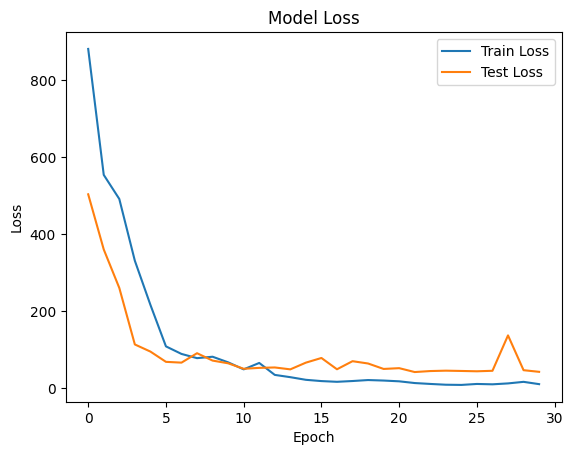

In [20]:
# Train loss와 Test loss 그래프 출력
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# 예측 결과 확인
y_pred = model.predict(X_test)

In [22]:
# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

Mean Absolute Error (MAE): 5.561236619949341
